In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import torchvision # JUST used for importing the image.

from dev_src.loss_fns import lpips_base_tf

2024-06-14 08:56:17.721428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 08:56:18.382845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BASE = 'alex' # options 'alex', 'vgg16', and 'squeeze'.
loss_tf = lpips_base_tf.LPIPS(BASE, pre_norm=True)

2024-06-14 08:56:20.905112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46774 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6
2024-06-14 08:56:20.905576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47358 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:1a:00.0, compute capability: 7.5


fetching base: alex
loading base parameters from file
loading lins parameters from file


In [3]:
image = torchvision.io.read_image(
    os.path.relpath('dev_src/data/image.png'), 
    torchvision.io.ImageReadMode.GRAY
).float()

image_noise = torchvision.io.read_image(
    os.path.relpath('dev_src/data/image_noise.png'), 
    torchvision.io.ImageReadMode.GRAY
).float()

image_noise_tf = tf.expand_dims(
    tf.transpose(
        tf.repeat(tf.convert_to_tensor(image_noise.numpy()), 3, 0),
            [2, 1, 0]
        ),
    0
) # Some reshaping for a format tf understands.

image_tf = tf.expand_dims(
    tf.transpose(
        tf.repeat(tf.convert_to_tensor(image.numpy()), 3, 0),
            [2, 1, 0]
        ),
    0
)

In [4]:
print(f'loss: {loss_tf(image_noise_tf, image_tf)}')

2024-06-14 08:56:21.696113: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


loss: [[[[0.44629833]]]]


# Integration test

Let's perform a quick integration test training a very basic CNN using this loss function.

In [5]:
from dev_src.utils.dummys import tf_model

model = tf_model.DummyModel()

model.network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_tf,
    metrics=["mean_squared_error"]
)

model.network.summary()

history = model.network.fit(
    image_noise_tf/255.,
    image_tf/255.,
    epochs=100
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 3)  │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,523 (13.76 KB)

 Trainable params: 3,523 (13.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1718319384.184551  875616 service.cc:145] XLA service 0x7f7f9800c4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718319384.184603  875616 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1718319384.184610  875616 service.cc:153]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2024-06-14 08:56:24.241371: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.7580 - mean_squared_error: 0.2243
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7487 - mean_squared_error: 0.2233
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7369 - mean_squared_error: 0.2218
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7244 - mean_squared_error: 0.2199
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7104 - mean_squared_error: 0.2178
Epoch 6/100


I0000 00:00:1718319386.352643  875616 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6925 - mean_squared_error: 0.2155
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6716 - mean_squared_error: 0.2130
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6494 - mean_squared_error: 0.2104
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6252 - mean_squared_error: 0.2076
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6026 - mean_squared_error: 0.2044
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5844 - mean_squared_error: 0.2010
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.5682 - mean_squared_error: 0.1974
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5503 - mean_squared_error: 0.1936
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5356 - mean_squared_error: 0.1899
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5212 - mean_squared_error: 0.1860
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5071 

In [6]:
image_denoise_tf = model.network(image_noise_tf/255., training=False)

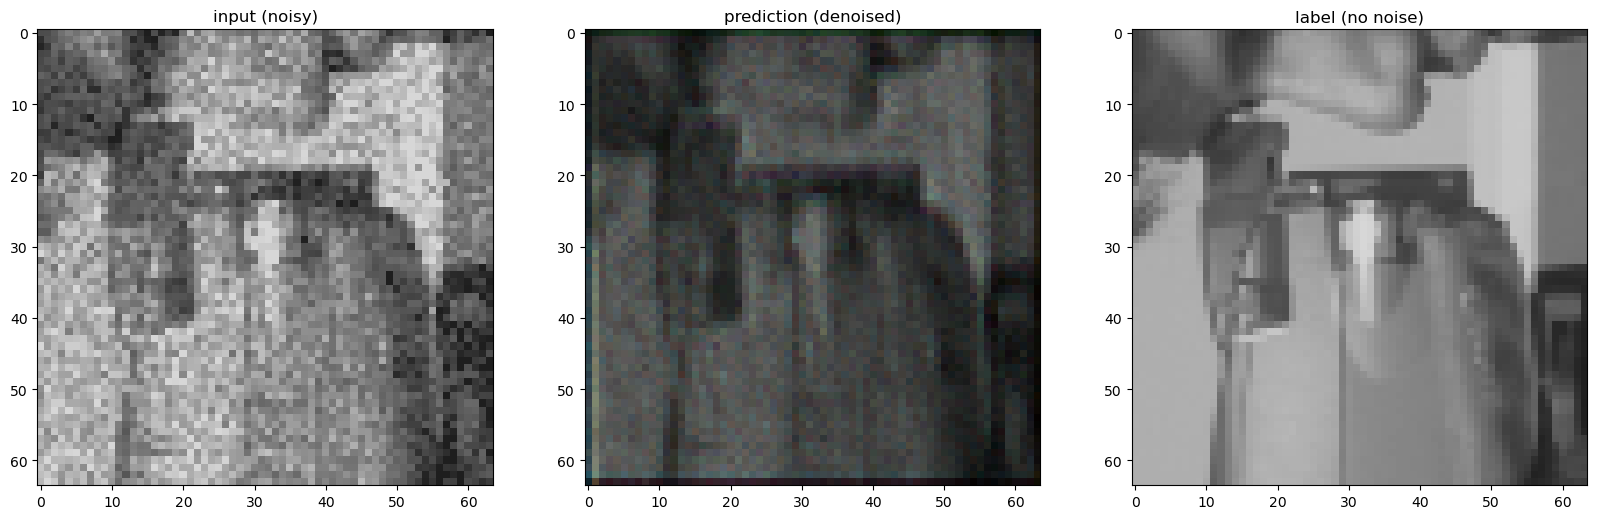

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(image_noise_tf[0].numpy().astype(int), cmap='gray')
ax[0].title.set_text('input (noisy)')
ax[1].imshow((image_denoise_tf[0].numpy()*255.).astype(int), cmap='gray')
ax[1].title.set_text('prediction (denoised)')
ax[2].imshow(image_tf[0].numpy().astype(int), cmap='gray')
ax[2].title.set_text('label (no noise)')
plt.show()

**OBVIOUSLY** this is not a machine learning pipeline you'd ever use (the testing and training data are the same). It is just demonstrating the use of the loss function on a very basic model.

Now what if we want to merge our perceptual loss (LPIPS) with a pixelwise loss (e.g., MSE)? Well that's easy

In [8]:
class LPIPSWithMSE:
    def __init__(self, lpips_loss: tf.keras.Model, alpha: float = 0.5):
        self.lpips_loss = lpips_loss
        self.alpha = alpha # a weighting term
    
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        loss_lpips = self.lpips_loss(y_true, y_pred)
        loss_mse = tf.reduce_mean(tf.square(y_true - y_pred))
        return self.alpha*loss_lpips + (1-self.alpha)*loss_mse

lpips_with_mse = LPIPSWithMSE(loss_tf)

In [9]:
# Reinstatiate the model.

model = tf_model.DummyModel()

model.network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lpips_with_mse.compute_loss,
    metrics=["mean_squared_error"]
)

model.network.summary()

history = model.network.fit(
    image_noise_tf/255.,
    image_tf/255.,
    epochs=100
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 3)  │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,523 (13.76 KB)

 Trainable params: 3,523 (13.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4665 - mean_squared_error: 0.2319
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4555 - mean_squared_error: 0.2266
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4455 - mean_squared_error: 0.2215
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.4362 - mean_squared_error: 0.2164
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4265 - mean_squared_error: 0.2114
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4172 - mean_squared_error: 0.2065
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4076 - mean_squared_error: 0.2018
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3981 - mean_squared_error: 0.1971
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3890 - mean_squared_error: 0.1925
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3802 - mean_squared_error: 0.1880
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.

In [10]:
image_denoise_tf = model.network(image_noise_tf/255., training=False)

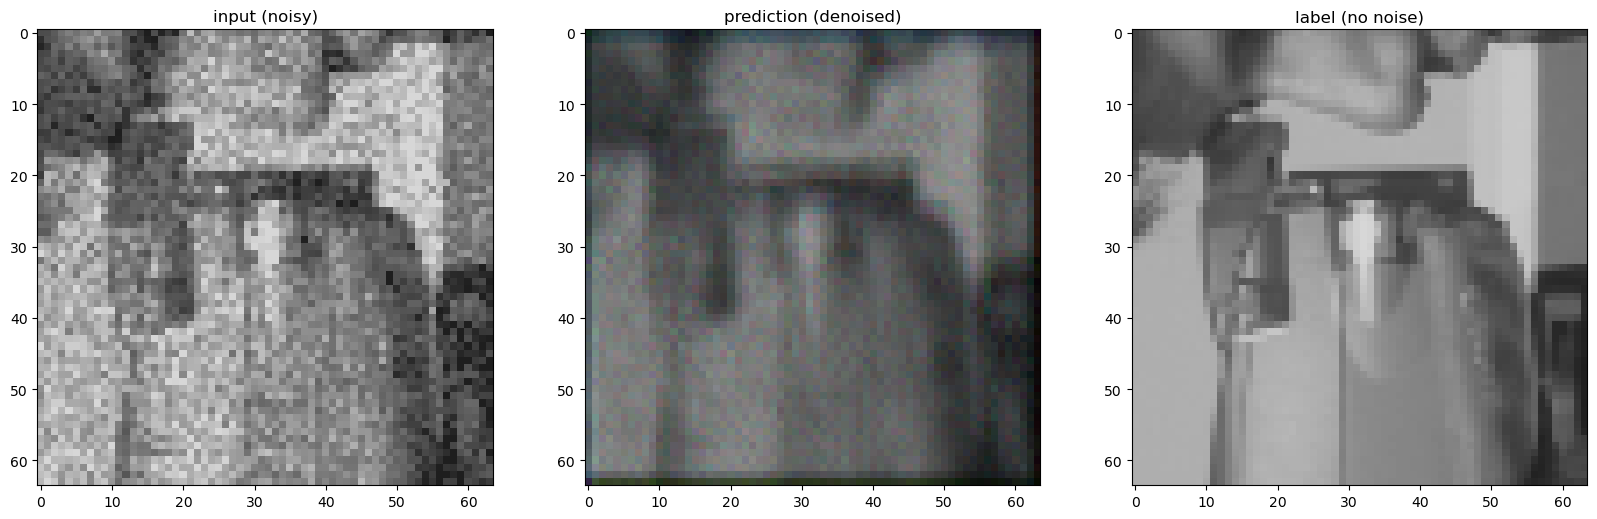

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(image_noise_tf[0].numpy().astype(int), cmap='gray')
ax[0].title.set_text('input (noisy)')
ax[1].imshow((image_denoise_tf[0].numpy()*255.).astype(int), cmap='gray')
ax[1].title.set_text('prediction (denoised)')
ax[2].imshow(image_tf[0].numpy().astype(int), cmap='gray')
ax[2].title.set_text('label (no noise)')
plt.show()

What about a batch size > 1? We simply repeat the input/label image to simulate this (again the training numbers don't matter, this is simply a demo of how the code could look).

In [12]:
image_noise_tf_batched = tf.repeat(
    image_noise_tf,
    4, # for argument's sake,
    0
)

image_tf_batched = tf.repeat(
    image_tf,
    4, # for argument's sake,
    0
)

print(image_noise_tf_batched.shape, image_tf_batched.shape)

(4, 64, 64, 3) (4, 64, 64, 3)


In [13]:
# Reinstatiate the model.

model = tf_model.DummyModel()

model.network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lpips_with_mse.compute_loss,
    metrics=["mean_squared_error"]
)

model.network.summary()

history = model.network.fit(
    image_noise_tf_batched/255.,
    image_tf_batched/255.,
    epochs=100
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 3)  │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,523 (13.76 KB)

 Trainable params: 3,523 (13.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5133 - mean_squared_error: 0.2659
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5080 - mean_squared_error: 0.2642
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5027 - mean_squared_error: 0.2629
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4970 - mean_squared_error: 0.2613
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4902 - mean_squared_error: 0.2594
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4828 - mean_squared_error: 0.2573
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4764 - mean_squared_error: 0.2551
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4691 - mean_squared_error: 0.2526
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4596 - mean_squared_error: 0.2499
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4494 - mean_squared_error: 0.2473
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.